# Classification

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import warnings
warnings.filterwarnings("ignore")

Just like in the previous chapter, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/classification` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them. The following code fetches the MNIST dataset:

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

By default the `fetch_openml()` function returns the inputs as a Pandas DataFrame and the labels as a Pandas Series. But DataFrame aren't ideal for images data, so it's preferable to set `as_frame=False`.

In [7]:
# extra code – it's a bit too long
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [8]:
mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black).

In [11]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [12]:
y.shape

(70000,)

In [13]:
28 * 28

784

Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using
Matplotlib’s `imshow()` function:

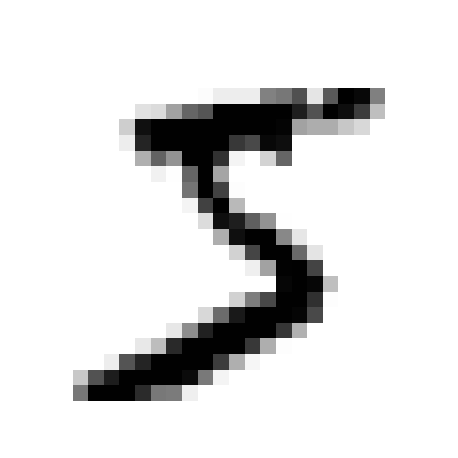

In [14]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [15]:
y[0]

'5'

Next figure shows a few more images from the MNIST dataset to give you a feel for
the complexity of the classification task.

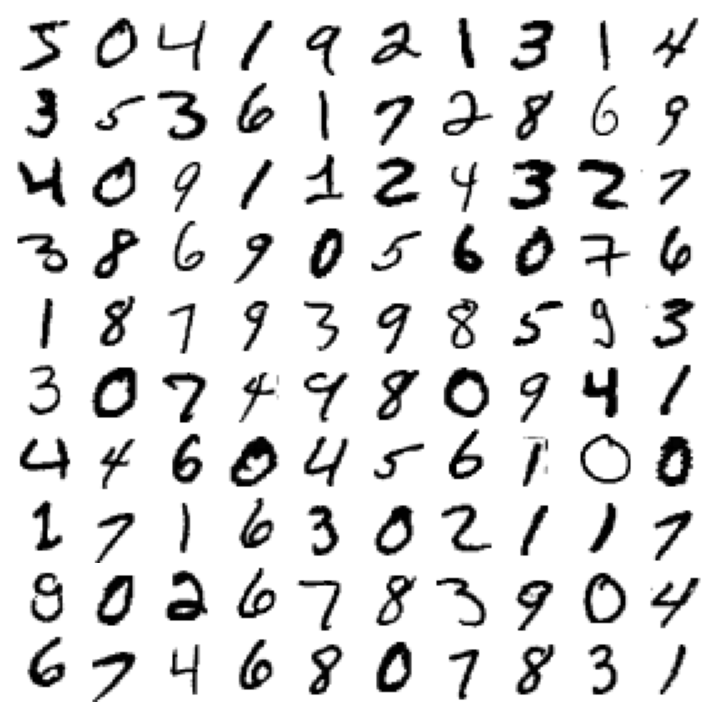

In [16]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

But wait! You should always create a test set and set it aside before inspecting the data
closely. The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5.

First, we will create the target vectors for
this classification task:

In [18]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

A good place to start is with a Stochastic
Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier
has the advantage of being capable of handling very large datasets efficiently.

Let’s create an SGDClassifier and train it on the whole training set:

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now you can use it to detect images of the number 5:

In [20]:
sgd_clf.predict([some_digit])

array([ True])

Looks like it guessed right
in this particular case! Now, let’s evaluate this model’s performance.

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this lecture on this topic.

## Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation. Let's use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using k-fold cross-validation with three folds.

In [21]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Occasionally you will need more control over the cross-validation process than what
Scikit-Learn provides off-the-shelf. In these cases, you can implement crossvalidation
yourself; it is actually fairly straightforward. The following code does
roughly the same thing as Scikit-Learn’s `cross_val_score()` function, and prints the
same result:

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds?
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class.

In [23]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [24]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion
matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets. You could make predictions on the test set, but
let’s keep it untouched for now (remember that you want to use the test set only at the
very end of your project, once you have a classifier that you are ready to launch).
Instead, you can use the `cross_val_predict()` function:

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each
instance in the training set (“clean” meaning that the prediction is made by a model
that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function.
Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred):

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents
a predicted class. The first row of this matrix considers non-5 images (the negative
class): 53,892 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 687 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,891 were wrongly
classified as non-5s (false negatives), while the remaining 3,530 were correctly classified
as 5s (true positives).

A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal
(top left to bottom right):

In [27]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision
and recall:

In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [29]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [31]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

Now your 5-detector does not look as shiny as it did when you looked at its accuracy.
When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover,
it only detects 65.1% of the 5s.

To compute the F1 score, simply call the *f1_score()* function

In [32]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [33]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

The F1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts
you really care about recall.

## Precision/Recall Trade-off

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
`predict()` method, you can call its `decision_function()` method, which returns a
score for each instance, and then make predictions based on those scores using any
threshold you want:

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [35]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [36]:
y_some_digit_pred

array([ True])

In [37]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
result as the predict() method (i.e., True). Let’s raise the threshold:

In [38]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 3,000.

Now how do you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the `cross_val_predict()` function
again, but this time specifying that you want it to return decision scores instead of
predictions:

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Now with these scores you can compute precision and recall for all possible thresholds
using the `precision_recall_curve()` function:

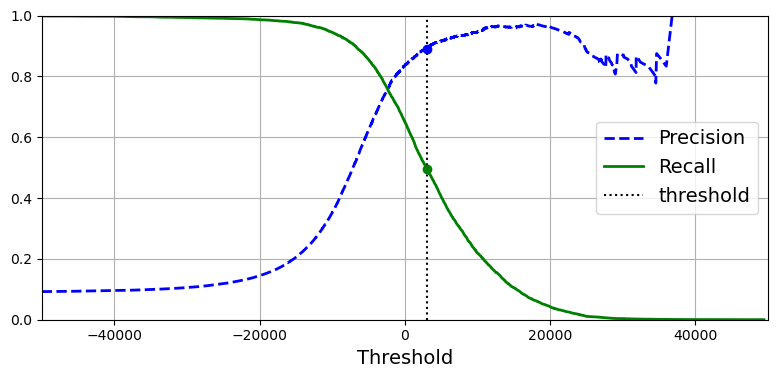

In [41]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly
against recall

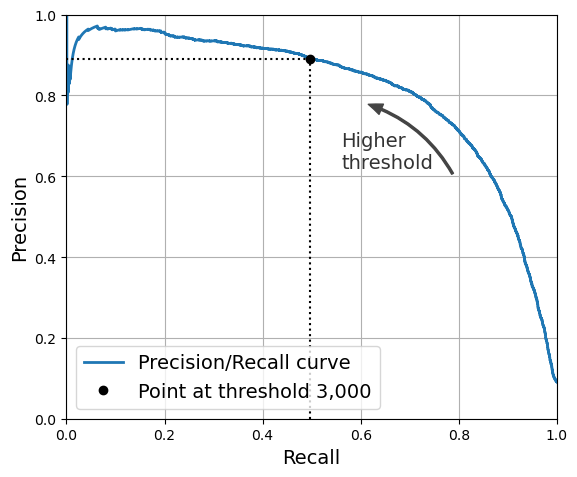

In [42]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall tradeoff just before that drop—for example,
at around 60% recall. But of course the choice depends on your project.

So let’s suppose you decide to aim for 90% precision.

In [43]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [44]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [45]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [46]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold
values, using the *roc_curve()* function:

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

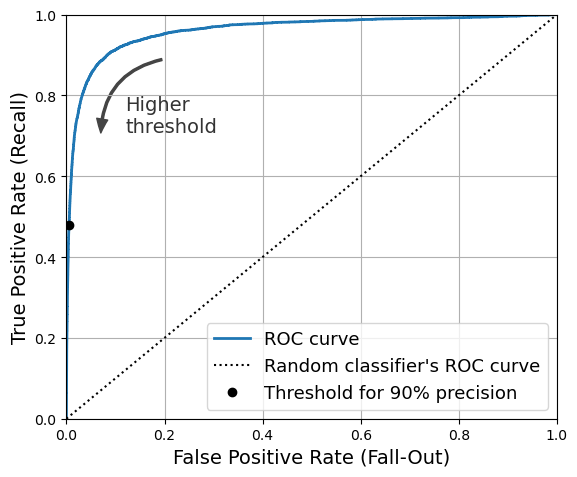

In [48]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [49]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright
corner).

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC
score to the SGDClassifier.

**Warning:** the following cell may take a few minutes to run.

In [50]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [51]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [52]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

These are _estimated probabilities_. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

In [53]:
# Not in the code
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [54]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

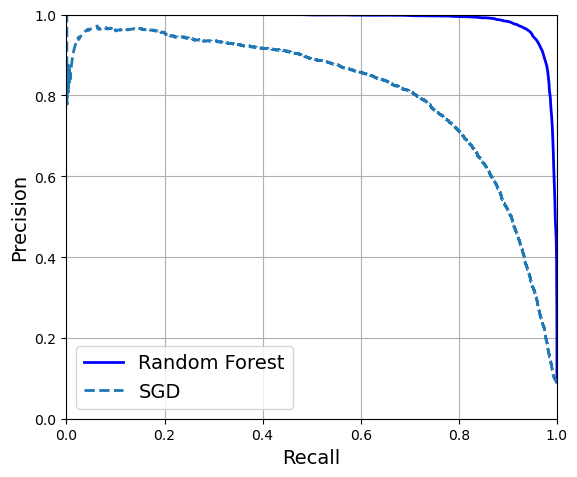

In [55]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

the RandomForestClassifier’s ROC curve looks much
better than the SGDClassifier’s: it comes much closer to the top-left corner. As a
result, its ROC AUC score is also significantly better

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [56]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [58]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [59]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.
Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers. However, there are various
strategies that you can use to perform multiclass classification using multiple
binary classifiers.

For example, one way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a
1-detector, a 2-detector, and so on). Then when you want to classify an image, you get
the decision score from each classifier for that image and you select the class whose
classifier outputs the highest score. This is called the one-versus-all (OvA) strategy
(also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish
0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advantage
of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set, so for these algorithms OvO is preferred since it is faster to
train many classifiers on small training sets than training few classifiers on large
training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO).

SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [60]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [61]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [62]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [63]:
class_id = some_digit_scores.argmax()
class_id

5

In [64]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [65]:
svm_clf.classes_[class_id]

'5'

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: `SVC` always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [66]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [67]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [68]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [69]:
len(ovr_clf.estimators_)

10

Training an `SGDClassifier` on a multiclass dataset and using it to make predictions is just as easy:

In [70]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [71]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

**Warning:** the following two cells may take a few minutes each to run:

In [72]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds. Not a bad score.

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

**Warning:** the following cell will take a few minutes to run:

First, you can look at the confusion matrix.

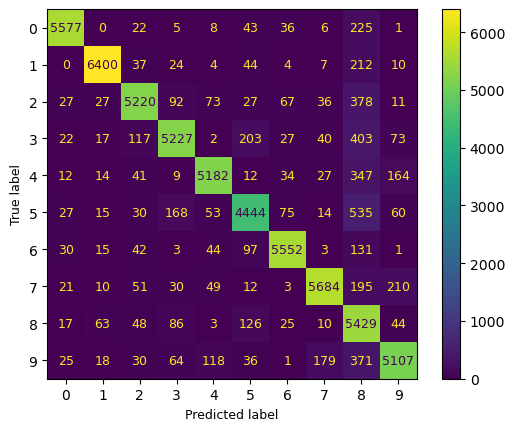

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

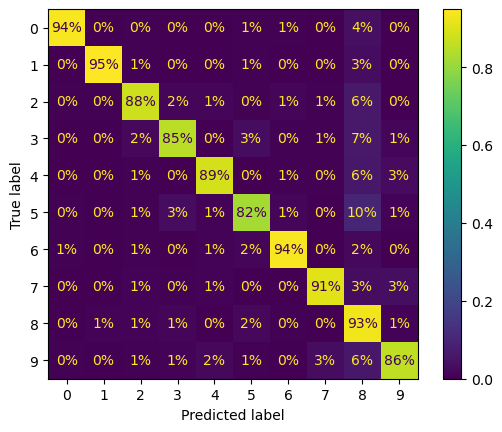

In [75]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

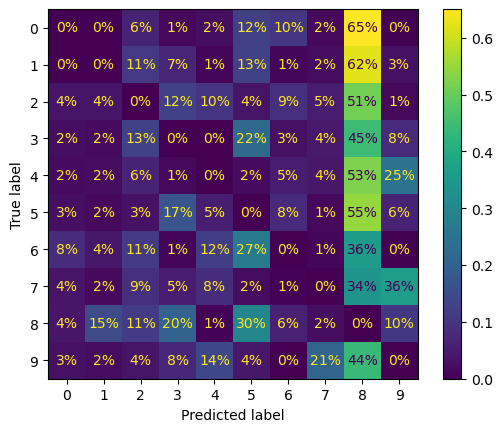

In [76]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

Let's put all plots in a couple of figures for the book:

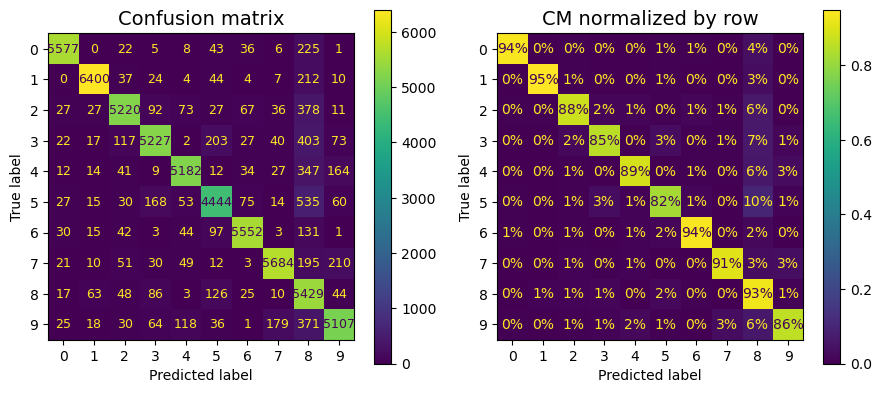

In [77]:
# extra code – this cell generates and saves Figure 3–9
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

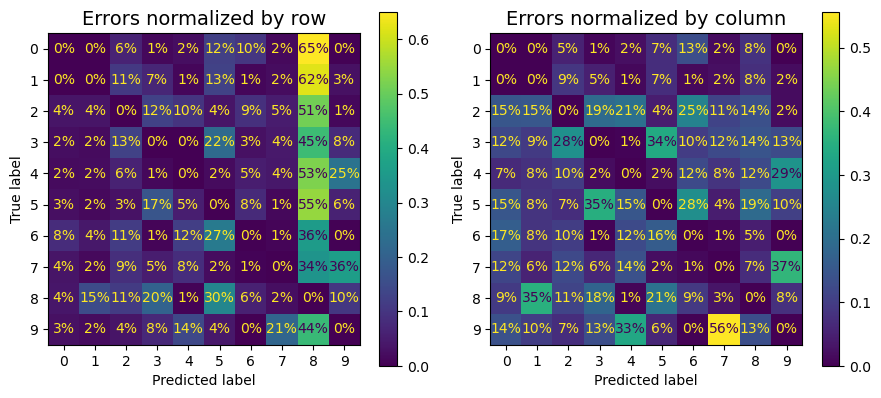

In [78]:
# extra code – this cell generates and saves Figure 3–10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

Analyzing individual errors can also be a good way to gain insights on what your
classifier is doing and why it is failing, but it is more difficult and time-consuming.For example, let’s plot examples of 3s and 5s

In [79]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

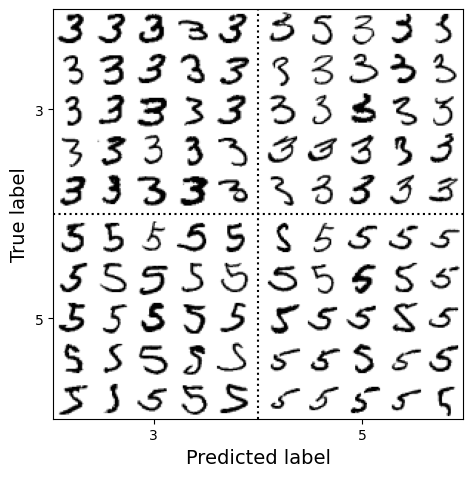

In [80]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

Note: there are several other ways you could code a plot like this one, but it's a bit hard to get the axis labels right:
* using [nested GridSpecs](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html)
* merging all the digits in each block into a single image (then using 2×2 subplots). For example:
    ```python
    X_aa[:25].reshape(5, 5, 28, 28).transpose(0, 2, 1, 3).reshape(5 * 28, 5 * 28)
    ```
* using [subfigures](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) (since Matplotlib 3.4)

# Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several people
on the same picture? Of course it should attach one tag per person it recognizes. Say
the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary tags is called a multilabel classification system.

We won’t go into face recognition just yet, but let’s look at a simpler example, just for
illustration purposes:

In [81]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a *y_multilabel* array containing two target labels for each digit
image: the first indicates whether or not the digit is large (7, 8, or 9) and the second
indicates whether or not it is odd. The next lines create a KNeighborsClassifier
instance (which supports multilabel classification, but not all classifiers do) and we
train it using the multiple targets array. Now you can make a prediction, and notice
that it outputs two labels:

In [82]:
knn_clf.predict([some_digit])

array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. For example, one approach is to measure the F1 score
for each individual label (or any other binary classifier metric discussed earlier), then
simply compute the average score. This code computes the average F1 score across all
labels:

**Warning**: the following cell may take a few minutes to run:

In [83]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, which may not be the case. In particular,
if you have many more pictures of Alice than of Bob or Charlie, you may want
to give more weight to the classifier’s score on pictures of Alice. One simple option is
to give each label a weight equal to its support (i.e., the number of instances with that
target label). To do this, simply set `average="weighted"` in the preceding code

In [84]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

SVC does not natively support multilabel classification. One possible strategy: train one model per label. Shortage: have a hard time capturing the dependencies between the labels. Solution: use a class called `ChainClassifier` .

In [85]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [86]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput Classification

The last type of classification task we are going to discuss here is called multioutputmulticlass
classification (or simply multioutput classification). It is simply a generalization
of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, represented
as an array of pixel intensities, just like the MNIST images. Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system.

In [87]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

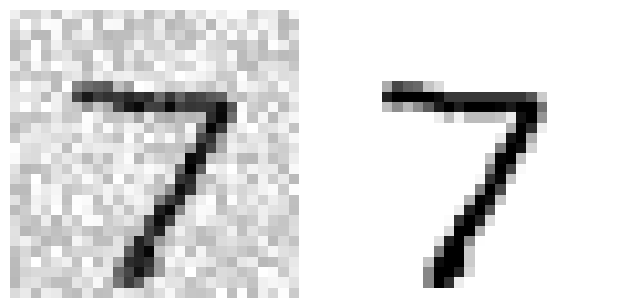

In [88]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

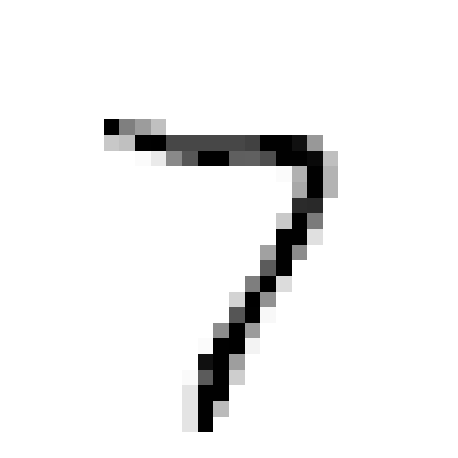

In [89]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()